# Generative Adversarial Networks (GANs)

In [ ]:
import torch
print(torch.__version__)

2.0.0+cu118


In [ ]:
print("GPU Available:", torch.cuda.is_available())

GPU Available: True


In [ ]:
if torch.cuda.is_available():
  device = torch.device("cuda:0")
else:
    device = "cpu"
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def generator_network(input_size, num_hidden_layers, num_hidden_units, num_output_units):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_g{i}', nn.Linear(input_size, num_hidden_units))
    model.add_module(f'relu_g{i}', nn.LeakyReLU())
    input_size = num_hidden_units
  model.add_module(f'fc_g{num_hidden_layers}', nn.Linear(input_size, num_output_units))
  model.add_module('tanh_g', nn.Tanh())
  return model

def discriminator_network(input_size, num_hidden_layers, num_hidden_units, num_out_units):
  model = nn.Sequential()
  for i in range(num_hidden_layers):
    model.add_module(f'fc_d{i}', nn.Linear(input_size, num_hidden_units, bias=False))
    model.add_module(f'relu_d{i}', nn.LeakyReLU())
    model.add_module('dropout', nn.Dropout(p=0.5))
    input_size = num_hidden_units
  model.add_module(f'fc_d{num_hidden_layers}', nn.Linear(input_size, num_out_units))
  model.add_module('sigmoid', nn.Sigmoid())
  return model

In [ ]:
image_size = (28, 28)
z_size = 20
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

torch.manual_seed(1)
gen_model = generator_network(input_size=z_size,
                              num_hidden_layers= gen_hidden_layers,
                              num_hidden_units=gen_hidden_size,
                              num_output_units=np.prod(image_size))
print(gen_model)

Sequential(
  (fc_g0): Linear(in_features=20, out_features=100, bias=True)
  (relu_g0): LeakyReLU(negative_slope=0.01)
  (fc_g1): Linear(in_features=100, out_features=784, bias=True)
  (tanh_g): Tanh()
)


In [ ]:
disc_model = discriminator_network(input_size=np.prod(image_size),
                                   num_hidden_layers= disc_hidden_layers,
                                   num_hidden_units = disc_hidden_size,
                                   num_out_units=1)

In [ ]:
print(disc_model)

Sequential(
  (fc_d0): Linear(in_features=784, out_features=100, bias=False)
  (relu_d0): LeakyReLU(negative_slope=0.01)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc_d1): Linear(in_features=100, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)




> `torchvision.transforms.ToTensor` function to convert the input image tensors to a tensor. As a result, besides changing the data type, calling this function will also change the range of input pixel intensities to [0, 1]. Then, we can shift them by –0.5 and scale them by a factor of 0.5 such that the pixel intensities will be rescaled to be in the range [–1, 1], which can improve gradient descent-based learning.



In [ ]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

In [ ]:
mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform = transform, download=True
)

example, label = next(iter(mnist_dataset))
print(f'Min:{example.min()} Max:{example.max()}')
print(example.shape)

100%|██████████| 9912422/9912422 [00:00<00:00, 166694243.06it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 17324899.00it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 149200513.38it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5396750.36it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Min:-1.0 Max:1.0
torch.Size([1, 28, 28])


In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size)*2 -1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size)
  return input_z

Training step-by-step

In [ ]:
from torch.utils.data import DataLoader
batch_size = 32
dataloader = DataLoader(mnist_dataset, batch_size, shuffle=False)
input_real, label = next(iter(dataloader))
# view(-1) operation flattens the tensor
input_real = input_real.view(batch_size, -1)
print('input-real -- shape:', input_real.shape)

input-real -- shape: torch.Size([32, 784])


In [ ]:
torch.manual_seed(1)
mode_z = 'normal'
input_z = create_noise(batch_size, z_size, mode_z)
print('input-z -- shape:', input_z.shape)

input-z -- shape: torch.Size([32, 20])


In [ ]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: torch.Size([32, 784])


In [ ]:
d_proba_real = disc_model(input_real)
d_proba_fake = disc_model(g_output)

In [ ]:
## binary cross-entropy loss
loss_fn = nn.BCELoss()
## Loss for the Generator
g_labels_real = torch.ones_like(d_proba_fake)
g_loss = loss_fn(d_proba_fake, g_labels_real)
print(f'Generator Loss: {g_loss:.4f}')



Generator Loss: 0.6860


In [ ]:
## Loss for the Discriminator
d_labels_real = torch.ones_like(d_proba_real)
d_labels_fake = torch.zeros_like(d_proba_fake)
d_loss_real = loss_fn(d_proba_real, d_labels_real)
d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)
print(f'Discriminator Losses: Real {d_loss_real:.4f} Fake {d_loss_fake:.4f}')

Discriminator Losses: Real 0.7479 Fake 0.7016


GAN model and implement the training loop

In [ ]:
batch_size = 64
torch.manual_seed(1)
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

gen_model = generator_network(input_size=z_size,
                              num_hidden_layers= gen_hidden_layers,
                              num_hidden_units=gen_hidden_size,
                              num_output_units=np.prod(image_size)).to(device)

disc_model = discriminator_network(input_size=np.prod(image_size),
                                   num_hidden_layers= disc_hidden_layers,
                                   num_hidden_units = disc_hidden_size,
                                   num_out_units=1).to(device)

In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters())
d_optimizer = torch.optim.Adam(disc_model.parameters())

In [ ]:
## Train the discriminator
def d_train(x):
  disc_model.zero_grad()
  # Train discriminator with a real batch
  batch_size = x.size(0)
  # x is input_real in step-by-step
  x = x.view(batch_size, -1).to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  # using zeros as 1-D(G(z)) or ground truth labels for the fake term is 0
  d_labels_fake = torch.zeros(batch_size, 1, device = device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize ONLY D's parameters
  d_loss = d_loss_fake + d_loss_real
  d_loss.backward()
  d_optimizer.step()
  # Tensor.detach(): returns a new Tensor, detached from the current graph
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
## Train the generator
def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size, 1, device = device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)

  # gradient backprop & optimize ONLY G's parameters
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [ ]:
# Generate examples from a fixed noise input using the current generator model after each epoch
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)
def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  # if use 'uniform' to create noise, return (images+1)/2.0
  return images

In [ ]:
# Each epoch, record the loss for the generator, the loss for the discriminator, and the loss for the real data and fake data respectively

epoch_samples = []
all_d_losses = []
all_g_losses = []
all_d_real = []
all_d_fake = []
num_epochs = 80

for epoch in range(1, num_epochs+1):
  # create (index, (input_real, label)) form enumerate()
  d_losses, g_losses = [], []
  d_vals_real, d_vals_fake = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    g_loss = g_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    d_vals_real.append(d_proba_real.mean().cpu())
    d_vals_fake.append(d_proba_fake.mean().cpu())

  all_d_losses.append(torch.tensor(d_losses).mean())
  all_g_losses.append(torch.tensor(g_losses).mean())
  all_d_real.append(torch.tensor(d_vals_real).mean())
  all_d_fake.append(torch.tensor(d_vals_fake).mean())

  print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {all_g_losses[-1]:.4f}/{all_d_losses[-1]:.4f}'
        f' [D-Real: {all_d_real[-1]:.4f}'
         f' D-Fake: {all_d_fake[-1]:.4f}]')
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())



Epoch 001 | Avg Losses >> G/D 0.9983/0.9134 [D-Real: 0.7911 D-Fake: 0.4646]
Epoch 002 | Avg Losses >> G/D 0.9103/1.2130 [D-Real: 0.5800 D-Fake: 0.4541]
Epoch 003 | Avg Losses >> G/D 0.9018/1.2421 [D-Real: 0.5682 D-Fake: 0.4530]
Epoch 004 | Avg Losses >> G/D 0.9129/1.2302 [D-Real: 0.5670 D-Fake: 0.4368]
Epoch 005 | Avg Losses >> G/D 0.8436/1.3023 [D-Real: 0.5381 D-Fake: 0.4572]
Epoch 006 | Avg Losses >> G/D 1.0539/1.1910 [D-Real: 0.5846 D-Fake: 0.4101]
Epoch 007 | Avg Losses >> G/D 0.9129/1.2550 [D-Real: 0.5596 D-Fake: 0.4362]
Epoch 008 | Avg Losses >> G/D 0.9028/1.2652 [D-Real: 0.5545 D-Fake: 0.4413]
Epoch 009 | Avg Losses >> G/D 0.8632/1.2764 [D-Real: 0.5466 D-Fake: 0.4472]
Epoch 010 | Avg Losses >> G/D 0.8512/1.2887 [D-Real: 0.5440 D-Fake: 0.4522]
Epoch 011 | Avg Losses >> G/D 0.9010/1.2471 [D-Real: 0.5652 D-Fake: 0.4369]
Epoch 012 | Avg Losses >> G/D 0.9416/1.2372 [D-Real: 0.5710 D-Fake: 0.4340]
Epoch 013 | Avg Losses >> G/D 0.9349/1.2343 [D-Real: 0.5697 D-Fake: 0.4289]
Epoch 014 | 

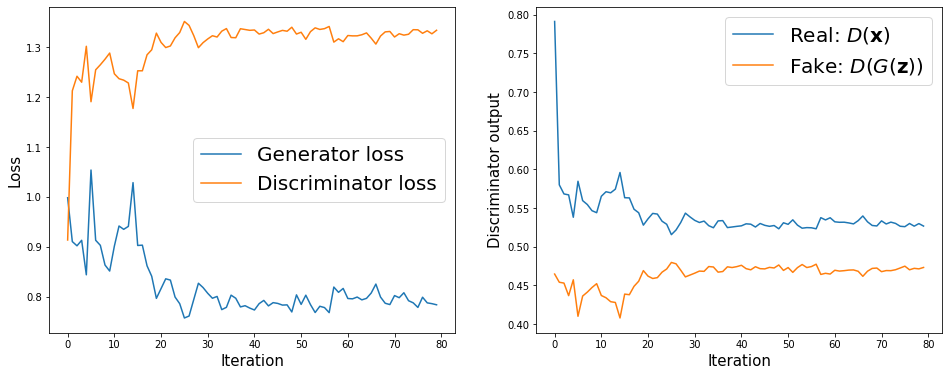

In [ ]:
## Plot the average probabilities of real and fake examples as computed by the discriminator in each iteration
## Expect these probabilities to be around 0.5 (discriminator unable to distinguish between real and fake images)
import itertools
fig = plt.figure(figsize = (16, 6))
## Plotting the losses
ax = fig.add_subplot(1, 2, 1)
plt.plot(all_g_losses, label='Generator loss')
# half_d_losses = [all_d_loss/2 for all_d_loss in all_d_losses]
plt.plot(all_d_losses, label='Discriminator loss')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

## Plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
plt.plot(all_d_real, label=r'Real: $D(\mathbf{x})$')
plt.plot(all_d_fake, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)
plt.show()

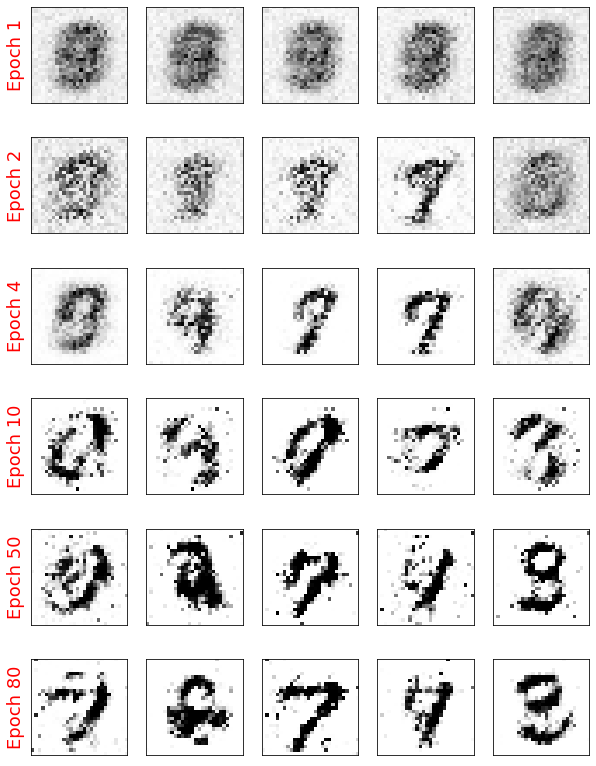

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 80]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red',
              horizontalalignment='right', verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

### **DCGAN**

In [ ]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform = transform, download=True
)

from torch.utils.data import DataLoader
batch_size = 32
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

The output spatial dimensions of` nn.ConvTranspose2d` are given by:

```
out = (x - 1)s - 2p + d(k - 1) + op + 1
```

where `x` is the input spatial dimension (not channels) and `out` the corresponding output size (not channels), `s` is the stride, `d` the dilation, `p` the padding,`k` the kernel size, and `op` the output padding.


In [ ]:
def make_generator(input_size, n_filters):
  model = nn.Sequential(
  ## nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, ...)
      nn.ConvTranspose2d(input_size, n_filters*4, 4, bias=False),
      nn.BatchNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
      nn.BatchNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
      nn.BatchNorm2d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
      nn.Tanh()
  )
  return model

class Discriminator(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*4, 1, 4, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
n_filters = 32
gen_model = make_generator(z_size, n_filters).to(device)
disc_model = Discriminator(n_filters).to(device)

In [ ]:
print(gen_model)

Sequential(
  (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2)
  (9): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): Tanh()
)


In [ ]:
print(disc_model)

Discriminator(
  (network): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1, 1)*2 -1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z

In [ ]:
## Train the discriminator
def d_train(x):
  disc_model.zero_grad()
  # Train discriminator with a real batch
  batch_size = x.size(0)
  # doesn't need to reshape the input image (unlike before)
  x = x.to(device)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_proba_real = disc_model(x)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  # using zeros as 1-D(G(z)) or ground truth labels for the fake term is 0
  d_labels_fake = torch.zeros(batch_size, 1, device = device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize ONLY D's parameters
  d_loss = d_loss_fake + d_loss_real
  d_loss.backward()
  d_optimizer.step()
  # Tensor.detach(): returns a new Tensor, detached from the current graph
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
## Train the generator
def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_labels_real = torch.ones(batch_size, 1, device = device)

  g_output = gen_model(input_z)
  d_proba_fake = disc_model(g_output)
  g_loss = loss_fn(d_proba_fake, g_labels_real)

  # gradient backprop & optimize ONLY G's parameters
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [ ]:
image_size = (28, 28)
torch.manual_seed(1)
mode_z = 'normal'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))
  # if use 'uniform' to create noise, return (images+1)/2.0
  return images

In [ ]:
epoch_samples = []
num_epochs = 50

for epoch in range(1, num_epochs+1):
  gen_model.train()
  # create (index, (input_real, label)) form enumerate()
  d_losses, g_losses = [], []
  for i, (x, _) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x)
    g_loss = g_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {torch.FloatTensor(g_losses).mean():.4f}/{torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_samples.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())


Epoch 001 | Avg Losses >> G/D 4.7029/0.1216
Epoch 002 | Avg Losses >> G/D 3.6695/0.2975
Epoch 003 | Avg Losses >> G/D 2.8749/0.3745
Epoch 004 | Avg Losses >> G/D 2.9585/0.3238
Epoch 005 | Avg Losses >> G/D 2.9843/0.3259
Epoch 006 | Avg Losses >> G/D 3.1095/0.3003
Epoch 007 | Avg Losses >> G/D 3.2758/0.2779
Epoch 008 | Avg Losses >> G/D 3.3440/0.2551
Epoch 009 | Avg Losses >> G/D 3.5763/0.2205
Epoch 010 | Avg Losses >> G/D 3.6987/0.2168
Epoch 011 | Avg Losses >> G/D 3.8498/0.1952
Epoch 012 | Avg Losses >> G/D 3.8744/0.2024
Epoch 013 | Avg Losses >> G/D 3.9399/0.1861
Epoch 014 | Avg Losses >> G/D 4.0645/0.1714
Epoch 015 | Avg Losses >> G/D 4.1090/0.1886
Epoch 016 | Avg Losses >> G/D 4.1510/0.1710
Epoch 017 | Avg Losses >> G/D 4.3003/0.1741
Epoch 018 | Avg Losses >> G/D 4.2946/0.1710
Epoch 019 | Avg Losses >> G/D 4.3045/0.1790
Epoch 020 | Avg Losses >> G/D 4.2624/0.1735
Epoch 021 | Avg Losses >> G/D 4.2610/0.1677
Epoch 022 | Avg Losses >> G/D 4.4627/0.1542
Epoch 023 | Avg Losses >> G/D 4.

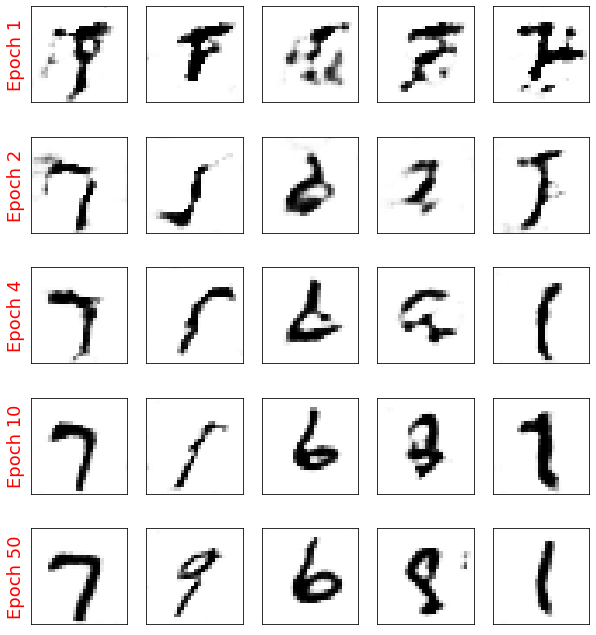

In [ ]:
selected_epochs = [1, 2, 4, 10, 50]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=18, color='red',
              horizontalalignment='right', verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

### **WGAN-GP**

Wasserstein (EM) distance : $W\left(\mathbb{P}_r, \mathbb{P}_g\right)=\inf _{\gamma \in \Pi\left(\mathbb{P}_r, \mathbb{P}_g\right)} \mathbb{E}_{(x, y) \sim \gamma}[\|x-y\|]$

Transformed based on the Kantorovich-Rubinstein duality: $W\left(\mathbb{P}_{\text {data }}, \mathbb{P}_{\text {model }}\right)=\frac{1}{K} \sup _{\|f\|_L \leq K}\left(\mathbb{E}_{\mathbf{x} \sim \mathbb{P}_{\text {data }}}[f(\mathbf{x})]-\mathbb{E}_{\mathbf{y} \sim \mathbb{P}_{\text {model }}}[f(\mathbf{y})]\right)$

Layer normalization: $y=\frac{x-\mathrm{E}[x]}{\sqrt{\operatorname{Var}[x]+\epsilon}} * \gamma+\beta$

In [ ]:
def make_generator_wgan(input_size, n_filters):
  model = nn.Sequential(
      ## nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, groups=1, bias=True, dilation=1, ...)
      nn.ConvTranspose2d(input_size, n_filters*4, 4, bias=False),
      # In WGAN, recommend to use layer normalization instead of batch normalization
      nn.InstanceNorm2d(n_filters*4),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*4, n_filters*2, 3, 2, 1, bias=False),
      nn.InstanceNorm2d(n_filters*2),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters*2, n_filters, 4, 2, 1, bias=False),
      nn.InstanceNorm2d(n_filters),
      nn.LeakyReLU(0.2),

      nn.ConvTranspose2d(n_filters, 1, 4, 2, 1, bias=False),
      nn.Tanh()
  )
  return model


In [ ]:
class DiscriminatorWGAN(nn.Module):
  def __init__(self, n_filters):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters, n_filters*2, 4, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*2, n_filters*4, 3, 2, 1, bias=False),
        nn.InstanceNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*4, 1, 4, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input):
    output = self.network(input)
    return output.view(-1, 1).squeeze(0)

**Initiate networks & optimizers**

In [ ]:
z_size = 100
n_filters = 32

gen_model = make_generator_wgan(z_size, n_filters).to(device)
disc_model = DiscriminatorWGAN(n_filters).to(device)

g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1, 1)*2 -1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z

**Computing grandient penalty**

Calculate the gradient penalty term by randomly interpolating between the real and fake samples and computing the gradient of the discriminator with respect to the interpolated samples.


1. Interpolate samples:
$$\hat{x}_{i} = \alpha x_i + (1 - \alpha) G(z_i; \theta_G)$$
where $\alpha$ is a random number between 0 and 1.
2. Calculate gradient of the discriminator w.r.t the interpolated samples:
$$\nabla_{\hat{x}_{i}} D(\hat{x}_{i}; \theta_D)$$
3. Compute gradient penalty term: $$\lambda (|\nabla_{\hat{x}_{i}} D(\hat{x}_{i}; \theta_D)|_2 - 1)^2$$
where $\lambda$ is a hyperparameter that controls the strength of the penalty.

In [ ]:
from torch.autograd import grad as torch_grad

def gradient_penalty(real_data, gen_data):
  batch_size = real_data.size(0)

  # Interpolate samples
  alpha = torch.rand(real_data.shape[0], 1, 1, 1, requires_grad=True, device=device)
  interpolated = alpha * real_data + (1 - alpha) * gen_data

  # Calculate probability of interpolated samples from discriminator
  prob_interpolated = disc_model(interpolated)

  # Calculate gradient of probability
  gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                         grad_outputs=torch.ones(prob_interpolated.size(), device=device),
                         create_graph=True, retain_graph=True)[0]
  gradients = gradients.view(batch_size, -1)
  gradients_norm = gradients.norm(2, dim=1)

  return lambda_gp * ((gradients_norm-1)**2).mean()

**Training**

In [ ]:
## Train the discriminator
def d_train_wgan(x):
  disc_model.zero_grad()

  # Train discriminator with a real batch
  batch_size = x.size(0)
  x = x.to(device)

  # Calculate probability on real and generated data
  d_real = disc_model(x)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)
  d_gen = disc_model(g_output)
  d_loss = d_gen.mean() - d_real.mean() + gradient_penalty(x.data, g_output.data)

  d_loss.backward()
  d_optimizer.step()

  return d_loss.data.item()

In [ ]:
## Train the generator
def g_train_wgan(x):
  gen_model.zero_grad()

  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  g_output = gen_model(input_z)

  d_gen = disc_model(g_output)
  g_loss = - d_gen.mean()

  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

**Data Loading**

In [ ]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform = transform, download=True
)

from torch.utils.data import DataLoader
batch_size = 32
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 151580719.21it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 25268188.12it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68696585.94it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7315871.26it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
image_size = (28, 28)
torch.manual_seed(1)
mode_z = 'normal'
fixed_z = create_noise(batch_size, z_size, mode_z).to(device)

def create_samples(g_model, input_z):
  g_output = g_model(input_z)
  images = torch.reshape(g_output, (batch_size, *image_size))

  # if use 'uniform' to create noise, return (images+1)/2.0
  return images

In [ ]:
epoch_samples_wgan = []
lambda_gp = 10.0
num_epochs = 10
critic_iterations = 5

for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses = [], []
  for i, (x, _) in enumerate(mnist_dl):
    for _ in range(critic_iterations):
      d_loss = d_train_wgan(x)
    g_loss = g_train_wgan(x)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {torch.FloatTensor(g_losses).mean():.4f}/{torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_samples_wgan.append(create_samples(gen_model, fixed_z).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D -0.2275/-0.3531
Epoch 002 | Avg Losses >> G/D -0.2037/-0.5646
Epoch 003 | Avg Losses >> G/D -0.2412/-0.5216
Epoch 004 | Avg Losses >> G/D -0.2778/-0.4678
Epoch 005 | Avg Losses >> G/D -0.2857/-0.4537
Epoch 006 | Avg Losses >> G/D -0.2883/-0.4424
Epoch 007 | Avg Losses >> G/D -0.2917/-0.4359
Epoch 008 | Avg Losses >> G/D -0.2948/-0.4203
Epoch 009 | Avg Losses >> G/D -0.2991/-0.4227
Epoch 010 | Avg Losses >> G/D -0.2979/-0.4206


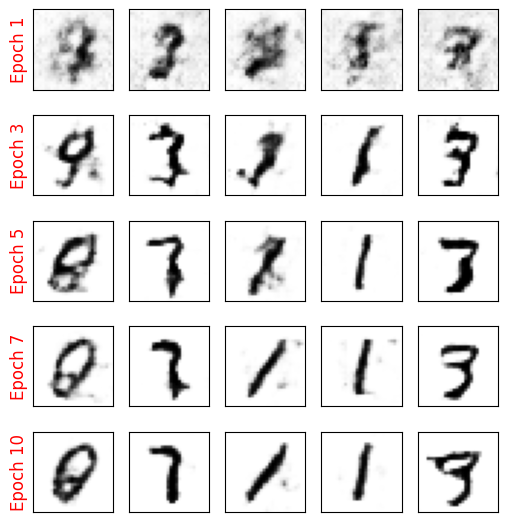

In [ ]:
selected_epochs = [1, 3, 5, 7, 10]
fig = plt.figure(figsize=(6, 8))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=12, color='red',
              horizontalalignment='right', verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples_wgan[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()

## **cDCGAN**

In [ ]:
class Generator(nn.Module):
  def __init__(self, input_size, label_size, n_filters):
    super().__init__()

    # For input: reduce out_channels by half compared with standard DCGAN
    self.hidden_input = nn.Sequential(
        nn.ConvTranspose2d(input_size, n_filters*4, 3, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2)
    )

    # For label
    self.hidden_label = nn.Sequential(
        nn.ConvTranspose2d(label_size, n_filters*4, 3, 1, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2)
    )

    # For [input,label]
    self.network = nn.Sequential(
        nn.ConvTranspose2d(n_filters*8, n_filters*4, 3, 2, 0, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*4, n_filters*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*2),
        nn.LeakyReLU(0.2),

        nn.ConvTranspose2d(n_filters*2, 1, 4, 2, 1, bias=False),
        nn.Tanh()
      )

  def forward(self, input, label):
      # z (input) size : (batch_size, 100, 1, 1)
      h1 = self.hidden_input(input)
      # label size : (batch_size, 10, 1, 1)
      h2 = self.hidden_label(label)
      x = torch.cat([h1, h2], 1)
      output = self.network(x)
      return output


class Discriminator(nn.Module):
  def __init__(self, label_size, n_filters):
    super().__init__()

    self.hidden_input = nn.Sequential(
        nn.Conv2d(1, n_filters, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2)
    )

    self.hidden_label = nn.Sequential(
        nn.Conv2d(label_size, n_filters, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2)
    )

    self.network = nn.Sequential(
        nn.Conv2d(n_filters*2, n_filters*4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(n_filters*4),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*4, n_filters*8, 3, 2, 0, bias=False),
        nn.BatchNorm2d(n_filters*8),
        nn.LeakyReLU(0.2),

        nn.Conv2d(n_filters*8, 1, 3, 1, 0, bias=False),
        nn.Sigmoid()
    )

  def forward(self, input, label):
    # (batch_size, 1, 28, 28) -> (batch_size, 32, 14, 14)
    h1 = self.hidden_input(input)
    # (batch_size, 10, 28, 28) -> (batch_size, 32, 14, 14)
    h2 = self.hidden_label(label)
    x = torch.cat([h1, h2], 1)
    output = self.network(x)
    # (batch_size, 1, 1, 1) -> (batch_size, 1)
    return output.view(-1, 1).squeeze(0)

In [ ]:
z_size = 100
label_size = 10
n_filters = 32
image_size = 28

gen_model = Generator(z_size, label_size, n_filters).to(device)
disc_model = Discriminator(label_size, n_filters).to(device)

In [ ]:
loss_fn = nn.BCELoss()
g_optimizer = torch.optim.Adam(gen_model.parameters(), 0.0003)
d_optimizer = torch.optim.Adam(disc_model.parameters(), 0.0002)

In [ ]:
def create_noise(batch_size, z_size, mode_z):
  if mode_z == 'uniform':
    input_z = torch.rand(batch_size, z_size, 1, 1)*2 -1
  elif mode_z == 'normal':
    input_z = torch.randn(batch_size, z_size, 1, 1)
  return input_z

In [ ]:
# Label Preprocess
# convert labels to onehot encoding
onehot = torch.zeros(label_size, label_size)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).view(label_size, 1), 1).view(label_size, label_size, 1, 1)
# reshape labels to image size, with number of labels as channel
fill = torch.zeros([label_size, label_size, image_size, image_size])
# channel corresponding to label will be set one and all other zeros
for i in range(label_size):
    fill[i, i, :, :] = 1

In [ ]:
## Train the discriminator
def d_train(x, labels):
  disc_model.zero_grad()
  # Train discriminator with a real batch
  batch_size = x.size(0)
  # doesn't need to reshape the input image (unlike before)
  x = x.to(device)
  # x_labels shape will be (batch_size, 10, 28, 28)
  x_labels = fill[labels].to(device)

  d_proba_real = disc_model(x, x_labels)
  d_labels_real = torch.ones(batch_size, 1, device=device)
  d_loss_real = loss_fn(d_proba_real, d_labels_real)

  # Train discriminator on a fake batch
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  # create random z_labels for generator
  z_labels = (torch.rand(batch_size, 1)*10).type(torch.LongTensor).squeeze()
  # convert genarator labels to onehot
  g_labels = onehot[z_labels].to(device)
  g_output = gen_model(input_z, g_labels)

  # preprocess labels for feeding as labels input in D
  dg_label = fill[z_labels].to(device)
  d_proba_fake = disc_model(g_output, dg_label)
  # using zeros as 1-D(G(z)) or ground truth labels for the fake term is 0
  d_labels_fake = torch.zeros(batch_size, 1, device = device)
  d_loss_fake = loss_fn(d_proba_fake, d_labels_fake)

  # gradient backprop & optimize ONLY D's parameters
  d_loss = d_loss_fake + d_loss_real
  d_loss.backward()
  d_optimizer.step()
  # Tensor.detach(): returns a new Tensor, detached from the current graph
  return d_loss.data.item(), d_proba_real.detach(), d_proba_fake.detach()

In [ ]:
## Train the generator
def g_train(x):
  gen_model.zero_grad()
  batch_size = x.size(0)
  input_z = create_noise(batch_size, z_size, mode_z).to(device)
  # create random labels for generator
  z_labels  = (torch.rand(batch_size, 1)*10).type(torch.LongTensor).squeeze()
  # convert genarator labels to onehot
  g_labels = onehot[z_labels].to(device)
  g_output = gen_model(input_z, g_labels)

  # preprocess labels for feeding as labels input in D
  dg_label = fill[z_labels].to(device)
  d_proba_fake = disc_model(g_output, dg_label)
  g_labels_real = torch.ones(batch_size, 1, device = device)
  g_loss = loss_fn(d_proba_fake, g_labels_real)

  # gradient backprop & optimize ONLY G's parameters
  g_loss.backward()
  g_optimizer.step()

  return g_loss.data.item()

In [ ]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5),
])

mnist_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True,
    transform = transform, download=True
)

from torch.utils.data import DataLoader
batch_size = 32
np.random.seed(1)
mnist_dl = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 299459155.01it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 99864545.61it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 179787646.47it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 15757261.18it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
torch.manual_seed(1)
mode_z = 'normal'
fixed_z = create_noise(label_size*10, z_size, mode_z).to(device)

fixed_c = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]*10).type(torch.LongTensor)
fixed_label = onehot[fixed_c].to(device)


def create_samples(g_model, input_z, labels):
  g_output = g_model(input_z, labels)
  images = torch.reshape(g_output, (label_size*10, *(image_size, image_size)))
  # if use 'uniform' to create noise, return (images+1)/2.0
  return images

In [ ]:
epoch_samples = []
num_epochs = 10

for epoch in range(1, num_epochs+1):
  gen_model.train()
  d_losses, g_losses = [], []
  for i, (x, labels) in enumerate(mnist_dl):
    d_loss, d_proba_real, d_proba_fake = d_train(x, labels)
    g_loss = g_train(x)
    d_losses.append(d_loss)
    g_losses.append(g_loss)

  print(f'Epoch {epoch:03d} | Avg Losses >>'
        f' G/D {torch.FloatTensor(g_losses).mean():.4f}/{torch.FloatTensor(d_losses).mean():.4f}')
  gen_model.eval()
  epoch_samples.append(create_samples(gen_model, fixed_z, fixed_label).detach().cpu().numpy())

Epoch 001 | Avg Losses >> G/D 5.7265/0.0824
Epoch 002 | Avg Losses >> G/D 4.1706/0.2434
Epoch 003 | Avg Losses >> G/D 3.1080/0.4484
Epoch 004 | Avg Losses >> G/D 2.2717/0.6882
Epoch 005 | Avg Losses >> G/D 1.9065/0.8012
Epoch 006 | Avg Losses >> G/D 1.7327/0.8372
Epoch 007 | Avg Losses >> G/D 1.6542/0.8652
Epoch 008 | Avg Losses >> G/D 1.6095/0.8552
Epoch 009 | Avg Losses >> G/D 1.6306/0.8515
Epoch 010 | Avg Losses >> G/D 1.6775/0.8321


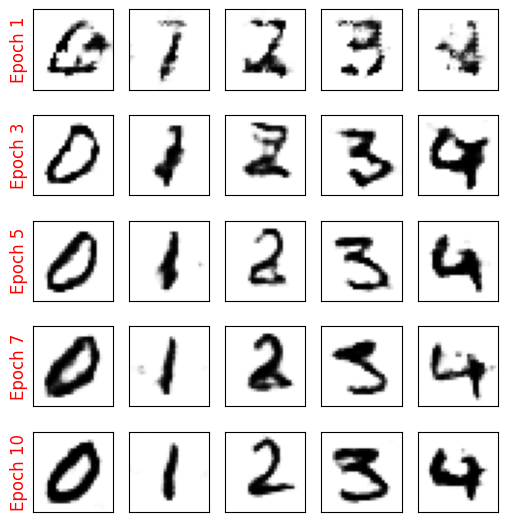

In [ ]:
selected_epochs = [1, 3, 5, 7, 10]
fig = plt.figure(figsize=(6, 8))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(-0.06, 0.5, f'Epoch {e}', rotation=90, size=12, color='red',
              horizontalalignment='right', verticalalignment='center',
              transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()